Screen Time Mental Health Prediction System
Part 1: Model Training

# Install required libraries

In [3]:
!pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

DATA LOADING & PREPROCESSING

In [9]:
def load_and_preprocess_data(file_path):
    """Load and preprocess the screen time dataset"""

    # Load data
    df = pd.read_csv(file_path)

    print("Dataset Shape:", df.shape)
    print("\nColumn Names:")
    print(df.columns.tolist())
    print("\nFirst few rows:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

    return df

def encode_categorical_features(df):
    """Encode all categorical features"""

    df_encoded = df.copy()
    label_encoders = {}

    # Define ordinal mappings
    ordinal_mappings = {
        'Average total screen time per day': {
            'Less than 1 hour': 0, '1–2 hours': 1, '3–4 hours': 2,
            '5–6 hours': 3, 'More than 6 hours': 4
        },
        'Educational content (hours)': {
            'Less than 1 hour': 0, '1–2 hours': 1, '3–4 hours': 2,
            '5–6 hours': 3, 'More than 6 hours': 4
        },
        'Social Media (hours)': {
            'Less than 1 hour': 0, '1–2 hours': 1, '3–4 hours': 2,
            '5–6 hours': 3, 'More than 6 hours': 4
        },
        'Entertainment (hours)': {
            'Less than 1 hour': 0, '1–2 hours': 1, '3–4 hours': 2,
            '5–6 hours': 3, 'More than 6 hours': 4
        },
        'Online communication (hours)': {
            'Less than 1 hour': 0, '1–2 hours': 1, '3–4 hours': 2,
            '5–6 hours': 3, 'More than 6 hours': 4
        },
        'Work / Productivity apps (hours)': {
            'Less than 1 hour': 0, '1–2 hours': 1, '3–4 hours': 2,
            '5–6 hours': 3, 'More than 6 hours': 4
        },
        'Online shopping / browsing (hours)': {
            'Less than 1 hour': 0, '1–2 hours': 1, '3–4 hours': 2,
            '5–6 hours': 3, 'More than 6 hours': 4
        },
        'Use screen before sleep': {
            'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3, 'Always': 4
        },
        'Tried reducing screen time': {
            'No': 0, 'Not sure': 1, 'Maybe': 2, 'Yes': 3
        },
        'Average sleep duration (hours)': {
            'Less than 5': 0, '5–6': 1, '6–7': 2, '7–8': 3, 'More than 8': 4
        },
        'Exercise frequency': {
            'Never': 0, '1–2 days per week': 1, '3–4 days per week': 2, 'Daily': 3
        },
        'Screen affects mental well-being': {
            'No': 0, 'Not sure': 1, 'Maybe': 2, 'Yes': 3
        },
        'Feel addicted to devices': {
            'No': 0, 'Not sure': 1, 'Maybe': 2, 'Yes': 3
        },
        'Try to limit screen time': {
            '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
        },
        'Track screen time': {
            '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
        }
    }

    # Apply ordinal encoding
    for col, mapping in ordinal_mappings.items():
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map(mapping)

    # Binary encoding for yes/no questions
    binary_cols = ['Open to screen-health app']
    for col in binary_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map({'Yes': 1, 'No': 0, 'Maybe': 0.5})

    # Label encoding for nominal categories
    nominal_cols = ['Age Group', 'Gender', 'Occupation', 'Field of study or work',
                    'Device used most frequently', 'Helpful features',
                    'Preferred feedback method', 'Motivation to reduce screen time']

    for col in nominal_cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            label_encoders[col] = le

    # Target variable
    if 'Mental_Health_Status' in df_encoded.columns:
        df_encoded['Mental_Health_Status'] = df_encoded['Mental_Health_Status'].map({
            'Healthy': 1, 'Unhealthy': 0
        })

    return df_encoded, label_encoders

def create_features(df):
    """Engineer additional features"""

    df_features = df.copy()

    # Screen time intensity score
    screen_cols = ['Educational content (hours)', 'Social Media (hours)',
                   'Entertainment (hours)', 'Online communication (hours)',
                   'Work / Productivity apps (hours)', 'Online shopping / browsing (hours)']

    available_cols = [col for col in screen_cols if col in df_features.columns]
    if available_cols:
        df_features['Total_Screen_Activity_Score'] = df_features[available_cols].sum(axis=1)
        df_features['Avg_Screen_Activity_Score'] = df_features[available_cols].mean(axis=1)

    # Behavioral risk score
    behavior_cols = ['Stress due to screen usage', 'Sleep affected by late use',
                     'Anxious without device', 'Compare with others', 'Lonely online']
    available_behavior = [col for col in behavior_cols if col in df_features.columns]
    if available_behavior:
        df_features['Behavioral_Risk_Score'] = df_features[available_behavior].sum(axis=1)

    # Physical symptoms score
    symptom_cols = ['Tired after long screen', 'Eye strain or headache', 'Depression symptoms']
    available_symptoms = [col for col in symptom_cols if col in df_features.columns]
    if available_symptoms:
        df_features['Physical_Symptom_Score'] = df_features[available_symptoms].sum(axis=1)

    # Sleep quality indicator
    if 'Sleep quality (1–5)' in df_features.columns and 'Average sleep duration (hours)' in df_features.columns:
        df_features['Sleep_Health_Score'] = df_features['Sleep quality (1–5)'] + df_features['Average sleep duration (hours)']

    # Self-awareness score
    awareness_cols = ['Tried reducing screen time', 'Screen affects mental well-being',
                      'Feel addicted to devices', 'Try to limit screen time']
    available_awareness = [col for col in awareness_cols if col in df_features.columns]
    if available_awareness:
        df_features['Self_Awareness_Score'] = df_features[available_awareness].sum(axis=1)

    return df_features

MODEL TRAINING

In [5]:
def train_models(X_train, X_test, y_train, y_test):
    """Train multiple ML models and compare performance"""

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        print('='*50)

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

        print(f"\nAccuracy: {accuracy:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"Cross-Validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Unhealthy', 'Healthy']))

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'cv_score': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }

        trained_models[name] = model

    return trained_models, results

def optimize_best_model(X_train, y_train):
    """Hyperparameter tuning for Random Forest"""

    print("\n" + "="*50)
    print("Hyperparameter Tuning - Random Forest")
    print("="*50)

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"Best ROC-AUC Score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

VISUALIZATION

In [6]:
def plot_results(results, feature_importance, feature_names):
    """Create comprehensive visualization of results"""

    fig = plt.figure(figsize=(20, 12))

    # 1. Model Comparison
    plt.subplot(2, 3, 1)
    models = list(results.keys())
    accuracies = [results[m]['accuracy'] for m in models]
    plt.bar(models, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

    # 2. ROC-AUC Comparison
    plt.subplot(2, 3, 2)
    roc_aucs = [results[m]['roc_auc'] for m in models]
    plt.bar(models, roc_aucs, color=['#9b59b6', '#f39c12', '#1abc9c'])
    plt.title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('ROC-AUC')
    plt.ylim([0, 1])
    for i, v in enumerate(roc_aucs):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

    # 3. Feature Importance (Top 15)
    plt.subplot(2, 3, 3)
    top_n = 15
    top_indices = np.argsort(feature_importance)[-top_n:]
    plt.barh(range(top_n), feature_importance[top_indices], color='#e67e22')
    plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()

    # 4. Confusion Matrix for best model (Random Forest)
    plt.subplot(2, 3, 4)
    cm = results['Random Forest']['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Unhealthy', 'Healthy'],
                yticklabels=['Unhealthy', 'Healthy'])
    plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # 5. Cross-Validation Scores
    plt.subplot(2, 3, 5)
    cv_scores = [results[m]['cv_score'] for m in models]
    cv_stds = [results[m]['cv_std'] for m in models]
    plt.bar(models, cv_scores, yerr=cv_stds, capsize=5, color=['#34495e', '#16a085', '#c0392b'])
    plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.ylabel('CV Score')
    plt.ylim([0, 1])

    # 6. Class Distribution
    plt.subplot(2, 3, 6)
    class_report = results['Random Forest']['classification_report']
    metrics = ['precision', 'recall', 'f1-score']
    unhealthy = [class_report['0'][m] for m in metrics]
    healthy = [class_report['1'][m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35
    plt.bar(x - width/2, unhealthy, width, label='Unhealthy', color='#e74c3c')
    plt.bar(x + width/2, healthy, width, label='Healthy', color='#2ecc71')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Classification Metrics by Class', fontsize=14, fontweight='bold')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim([0, 1])

    plt.tight_layout()
    plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

MAIN EXECUTION

SCREEN TIME MENTAL HEALTH PREDICTION SYSTEM

[1/7] Loading Data...
Dataset Shape: (500, 37)

Column Names:
['Age Group', 'Gender', 'Occupation', 'Field of study or work', 'Average total screen time per day', 'Device used most frequently', 'Educational content (hours)', 'Social Media (hours)', 'Entertainment (hours)', 'Online communication (hours)', 'Work / Productivity apps (hours)', 'Online shopping / browsing (hours)', 'Use screen before sleep', 'Tried reducing screen time', 'Stress due to screen usage', 'Sleep affected by late use', 'Anxious without device', 'Compare with others', 'Lonely online', 'Tired after long screen', 'Eye strain or headache', 'Depression symptoms', 'Average sleep duration (hours)', 'Sleep quality (1–5)', 'Exercise frequency', 'Screen affects mental well-being', 'Feel addicted to devices', 'Try to limit screen time', 'Track screen time', 'Take regular breaks', 'Prioritize real-world activities', 'Screen time under control', 'Open to screen-health app', 'Helpfu

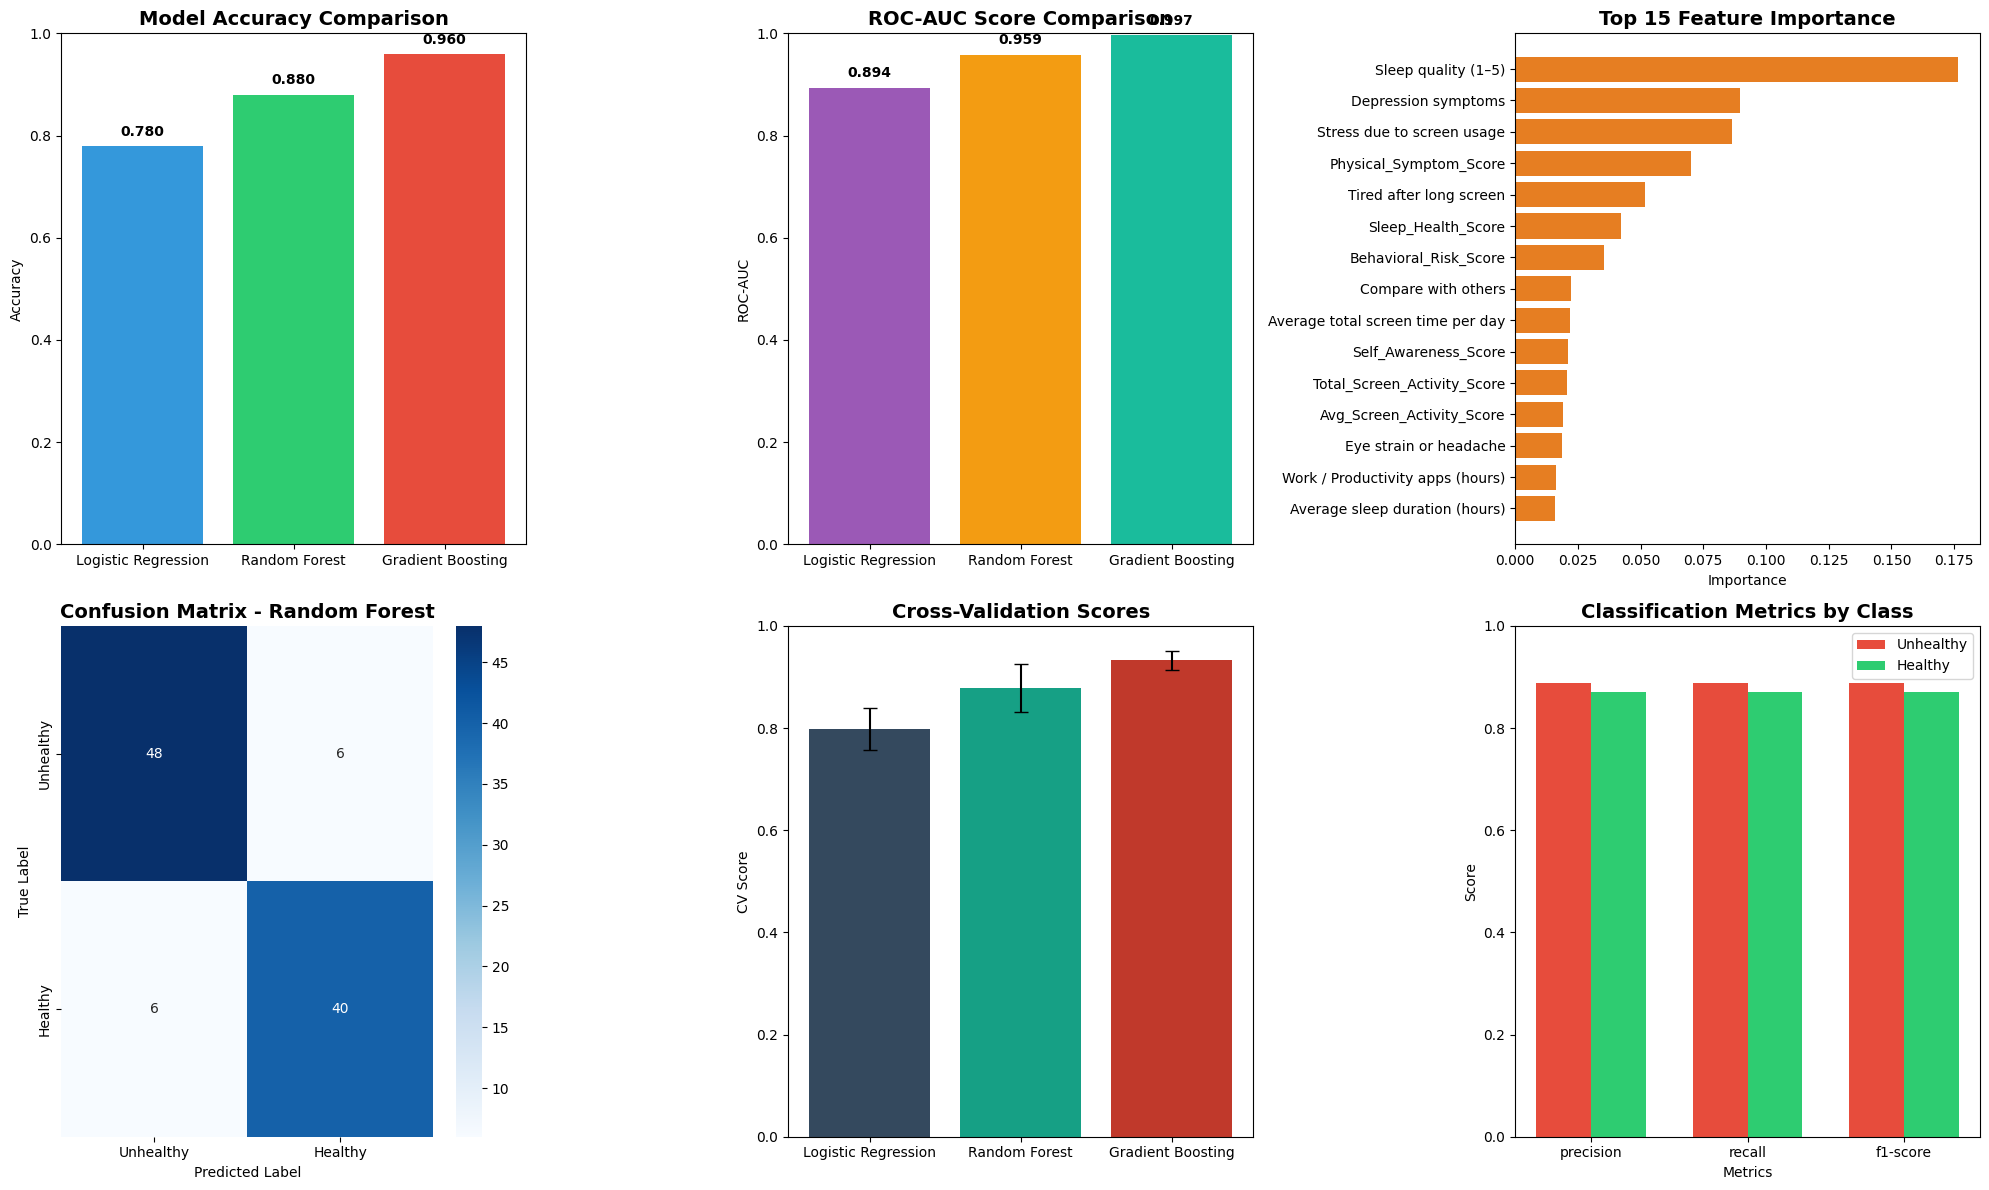


Saving Models and Preprocessing Objects...

TRAINING COMPLETE!

Saved Files:
  - mental_health_predictor.pkl
  - feature_scaler.pkl
  - label_encoders.pkl
  - feature_names.pkl
  - model_performance_analysis.png


In [7]:
def main():
    """Main execution pipeline"""

    print("="*70)
    print("SCREEN TIME MENTAL HEALTH PREDICTION SYSTEM")
    print("="*70)

    # Load data
    print("\n[1/7] Loading Data...")
    df = load_and_preprocess_data('/content/screen_time_survey_500.csv')

    # Encode features
    print("\n[2/7] Encoding Features...")
    df_encoded, label_encoders = encode_categorical_features(df)

    # Feature engineering
    print("\n[3/7] Engineering Features...")
    df_features = create_features(df_encoded)

    # Prepare data for modeling
    print("\n[4/7] Preparing Data for Modeling...")

    # Remove target and non-predictive columns
    target = 'Mental_Health_Status'
    X = df_features.drop([target], axis=1)
    y = df_features[target]

    # Handle any remaining missing values more robustly
    # Check if there are any NaNs before attempting to fill
    if X.isnull().any().any(): # Check if there's any NaN in the entire DataFrame
        print("NaNs detected in features. Attempting to fill...")
        for col in X.columns:
            if X[col].isnull().any():
                median_val = X[col].median()
                if pd.isna(median_val):
                    # If median is NaN (column is all NaNs), fill with 0
                    X[col] = X[col].fillna(0)
                else:
                    X[col] = X[col].fillna(median_val)
        print("NaNs handling complete. Verifying...")
        if X.isnull().any().any():
            print("WARNING: NaNs still present after filling. This might indicate an issue with data generation.")
            print(X.isnull().sum()[X.isnull().sum() > 0])
        else:
            print("All NaNs successfully handled.")
    else:
        print("No NaNs detected in features.")

    print(f"\nFeatures shape: {X.shape}")
    print(f"Target distribution:\n{y.value_counts()}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Handle class imbalance with SMOTE
    print("\n[5/7] Handling Class Imbalance...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    print(f"Original training set distribution: {np.bincount(y_train)}")
    print(f"Balanced training set distribution: {np.bincount(y_train_balanced)}")

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    print("\n[6/7] Training Models...")
    trained_models, results = train_models(X_train_scaled, X_test_scaled,
                                          y_train_balanced, y_test)

    # Optimize best model
    print("\n[7/7] Optimizing Best Model...")
    best_model = optimize_best_model(X_train_scaled, y_train_balanced)

    # Final evaluation
    y_pred_final = best_model.predict(X_test_scaled)
    final_accuracy = accuracy_score(y_test, y_pred_final)
    print(f"\nFinal Optimized Model Accuracy: {final_accuracy:.4f}")

    # Feature importance
    feature_importance = best_model.feature_importances_
    feature_names = X.columns.tolist()

    # Visualize results
    print("\nGenerating Visualizations...")
    plot_results(results, feature_importance, feature_names)

    # Save models and preprocessing objects
    print("\nSaving Models and Preprocessing Objects...")
    joblib.dump(best_model, 'mental_health_predictor.pkl')
    joblib.dump(scaler, 'feature_scaler.pkl')
    joblib.dump(label_encoders, 'label_encoders.pkl')
    joblib.dump(feature_names, 'feature_names.pkl')

    print("\n" + "="*70)
    print("TRAINING COMPLETE!")
    print("="*70)
    print("\nSaved Files:")
    print("  - mental_health_predictor.pkl")
    print("  - feature_scaler.pkl")
    print("  - label_encoders.pkl")
    print("  - feature_names.pkl")
    print("  - model_performance_analysis.png")

    return best_model, scaler, label_encoders, feature_names, results

# Run the pipeline
if __name__ == "__main__":
    model, scaler, encoders, features, results = main()

In [10]:
from google.colab import files
files.download('mental_health_predictor.pkl')
files.download('feature_scaler.pkl')
files.download('label_encoders.pkl')
files.download('feature_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>